In [1]:
from cobra.io import read_sbml_model
from cobra import Reaction
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
from cobra.flux_analysis import moma
import numpy as np

model = read_sbml_model('iML1515.xml')

In [42]:
# media
with model:
    medium = model.medium
    medium['EX_glc__D_e'] = 30
    medium['EX_rib__D_e'] = 1000
    model.medium = medium

#     # gene knockout
    model.genes.get_by_id("b0677").knock_out()
    model.genes.get_by_id("b0678").knock_out()
    model.genes.get_by_id("b0679").knock_out()
    model.genes.get_by_id("b1817").knock_out()
    model.genes.get_by_id("b1818").knock_out()
    model.genes.get_by_id("b1819").knock_out()
    model.genes.get_by_id("b1101").knock_out()
#     model.genes.get_by_id("b2415").knock_out()
#     model.genes.get_by_id("b2416").knock_out()
#     model.genes.get_by_id("b2417").knock_out()

#     # gene integration
    reaction = Reaction("ExRe1")
    reaction.name = "GlcNAc-6-P N-Acetyltransferase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("accoa_c"): -1.0,
        model.metabolites.get_by_id("gam6p_c"): -1.0,
        model.metabolites.get_by_id("acgam6p_c"): 1.0,
        model.metabolites.get_by_id("coa_c"): 1.0
    })
    model.add_reactions([reaction])

    reaction = Reaction("ExRe2")
    reaction.name = "GlcNAc-6-P phosphatase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("acgam6p_c"): -1.0,
        model.metabolites.get_by_id("adp_c"): -1.0,
        model.metabolites.get_by_id("atp_c"): 1.0,
        model.metabolites.get_by_id("acgam_p"): 1.0
    })
    model.add_reactions([reaction])

    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45
    model.objective = model.reactions.EX_acgam_e
    solution = model.optimize()

    print(solution.objective_value)
    print(solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])

478.92187781603633
0.45


# Check genes

In [17]:
genes = ["b0677", "b0678", "b0679", "b1817", "b1818", "b1819", "b1101", "b2415", "b2416", "b2417"]
essentiality = {}
for gene in genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

In [18]:
essentiality

{'b0677': 0.8769972144269641,
 'b0678': 0.876997214426954,
 'b0679': 0.876997214426954,
 'b1817': 0.876997214426954,
 'b1818': 0.876997214426954,
 'b1819': 0.876997214426954,
 'b1101': 0.876997214426954,
 'b2415': 0.8675930236571694,
 'b2416': 0.8675930236571694,
 'b2417': 0.8769972144269657}

<AxesSubplot: ylabel='Frequency'>

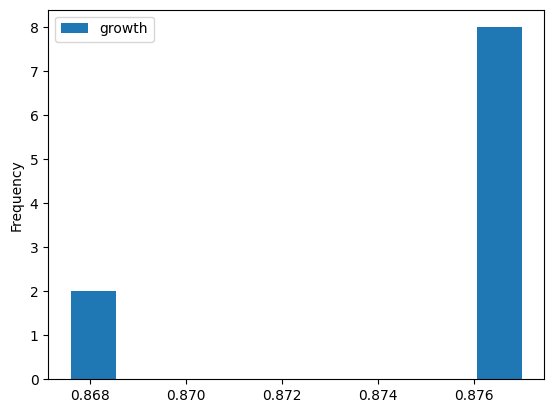

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')
df.plot.hist()

23.557180051486593
23.557180051486593
0.45
23.557180051486434
23.557180051486434
0.45


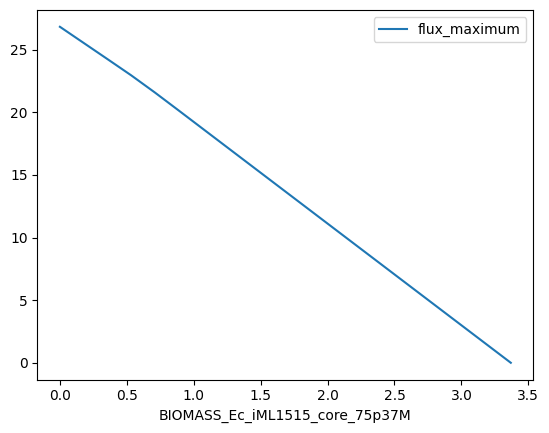

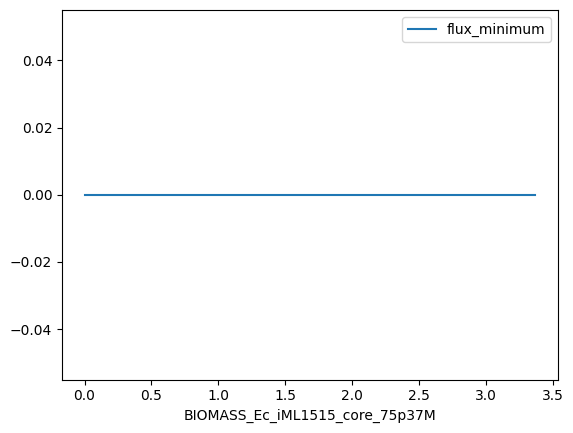

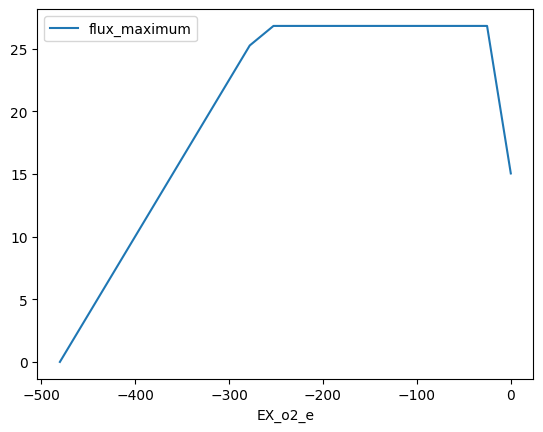

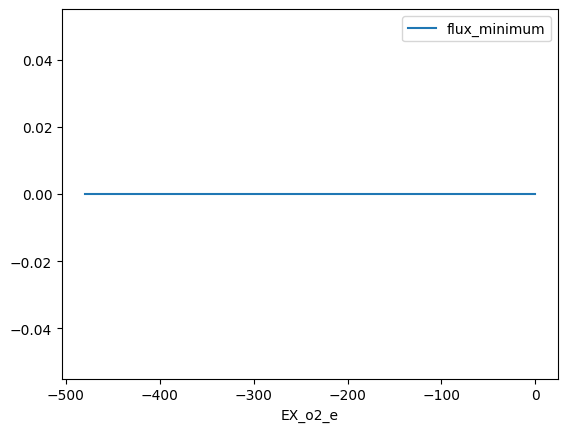

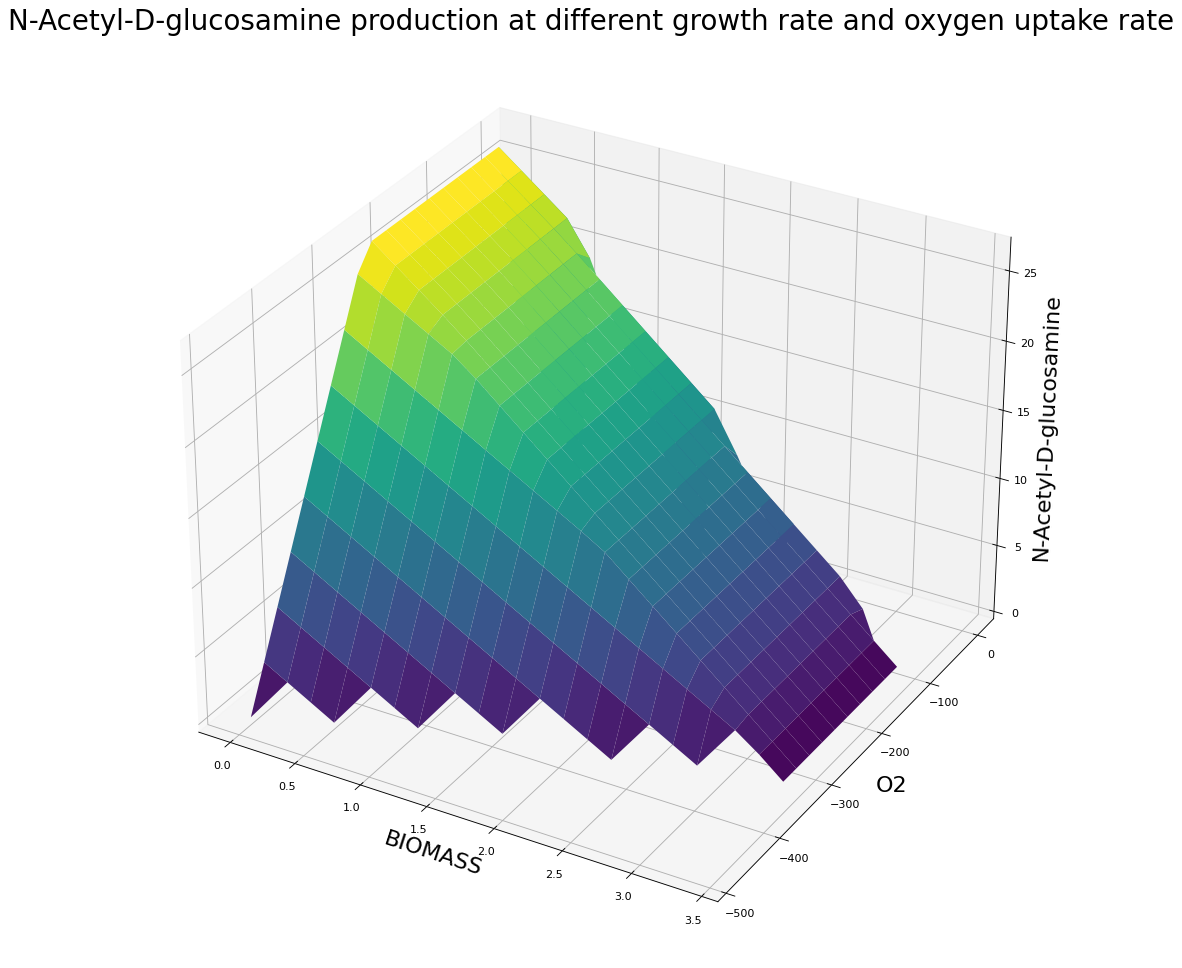

In [20]:
# media
with model:
    medium = model.medium
    medium['EX_glc__D_e'] = 30
    medium['EX_rib__D_e'] = 10
    model.medium = medium

    # gene knockout
    model.genes.get_by_id("b0677").knock_out()
    model.genes.get_by_id("b0678").knock_out()
    model.genes.get_by_id("b0679").knock_out()
    model.genes.get_by_id("b1817").knock_out()
    model.genes.get_by_id("b1818").knock_out()
    model.genes.get_by_id("b1819").knock_out()
    model.genes.get_by_id("b1101").knock_out()
    model.genes.get_by_id("b2415").knock_out()
    model.genes.get_by_id("b2416").knock_out()
    model.genes.get_by_id("b2417").knock_out()

    # gene integration
    reaction = Reaction("ExRe1")
    reaction.name = "GlcNAc-6-P N-Acetyltransferase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("accoa_c"): -1.0,
        model.metabolites.get_by_id("gam6p_c"): -1.0,
        model.metabolites.get_by_id("acgam6p_c"): 1.0,
        model.metabolites.get_by_id("coa_c"): 1.0
    })
    model.add_reactions([reaction])
    reaction = Reaction("ExRe2")
    reaction.name = "GlcNAc-6-P phosphatase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("acgam6p_c"): -1.0,
        model.metabolites.get_by_id("adp_c"): -1.0,
        model.metabolites.get_by_id("atp_c"): 1.0,
        model.metabolites.get_by_id("acgam_p"): 1.0
    })
    model.add_reactions([reaction])

    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45
    model.objective = model.reactions.EX_acgam_e
    solution = model.optimize()

    print(solution.fluxes["ExRe1"])
    print(solution.fluxes["ExRe2"])   
    print(solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])

    moma_res = moma(model, solution)
    print(moma_res.fluxes["ExRe1"])
    print(moma_res.fluxes["ExRe2"])   
    print(moma_res.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])

    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0

    # #     # PPP
    growth = production_envelope(model, reactions=model.reactions.BIOMASS_Ec_iML1515_core_75p37M, 
                               objective=model.reactions.ExRe2)
    growth.plot(x='BIOMASS_Ec_iML1515_core_75p37M', y='flux_maximum')
    growth.plot(x="BIOMASS_Ec_iML1515_core_75p37M", y= "flux_minimum")  

    oxy = production_envelope(model, reactions=model.reactions.EX_o2_e, 
                               objective=model.reactions.EX_acgam_e)
    oxy.plot(x='EX_o2_e', y='flux_maximum')
    oxy.plot(x="EX_o2_e", y= "flux_minimum")  

    result_3D = production_envelope(model, reactions=[model.reactions.BIOMASS_Ec_iML1515_core_75p37M, model.reactions.EX_o2_e],
                                   objective=model.reactions.EX_acgam_e)
    fig = plt.figure(figsize=(15, 15), dpi=80)
    ax = plt.axes(projection='3d')
    ax.plot_surface(np.reshape(np.asarray(result_3D.BIOMASS_Ec_iML1515_core_75p37M), (-1, 20)), 
                    np.reshape(np.asarray(result_3D.EX_o2_e), (-1, 20)), 
                    np.reshape(np.asarray(result_3D.flux_maximum), (-1, 20)),
                    rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('N-Acetyl-D-glucosamine production at different growth rate and oxygen uptake rate', fontsize=25)
    ax.set_xlabel('BIOMASS', fontsize=20, rotation = 0)
    ax.set_ylabel('O2', fontsize=20, rotation = 0)
    ax.set_zlabel('N-Acetyl-D-glucosamine', fontsize=20, rotation = 0)

# FVA

In [6]:
from cameo import flux_variability_analysis as flux_vari_analysis
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
import warnings
warnings.filterwarnings("ignore")

plotter = PlotlyPlotter()

In [26]:
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

# gene knockout
model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

# gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("accoa_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("coa_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("adp_c"): -1.0,
    model.metabolites.get_by_id("atp_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])
model.objective = model.reactions.EX_acgam_e

Ignoring reaction 'ExRe1' since it already exists.
Ignoring reaction 'ExRe2' since it already exists.


In [27]:
fva_result = flux_vari_analysis(model)

In [80]:
import warnings
warnings.filterwarnings('ignore')
fva_result.plot(plotter,
                index=["GLNS", "PYK3"],
                title="Flux Variability Analysis (fraction_of_optimum=0.0)" 
               )

In [81]:
import warnings
warnings.filterwarnings('ignore')
fva_result.plot(plotter,
                index=["ExRe2", "ExRe1", "BIOMASS_Ec_iML1515_core_75p37M", "GF6PTA"],
                title="Flux Variability Analysis (fraction_of_optimum=0.0)" 
               )

In [29]:
fva_result2 = flux_vari_analysis(model,fraction_of_optimum=0.95)

In [82]:
fva_result2.plot(plotter,
                index=["GLNS", "PYK3"],
                 title="Flux Variability Analysis (fraction_of_optimum=0.95)",
               )

In [83]:
fva_result2.plot(plotter,
                index=["ExRe2", "ExRe1", "BIOMASS_Ec_iML1515_core_75p37M", "GF6PTA"],
                 title="Flux Variability Analysis (fraction_of_optimum=0.95)",
               )

In [126]:
from cobra.flux_analysis import flux_variability_analysis
x=[]
y=[]
z=[]
k=[]
m=[]
Biomass=[]
Productivity1=[]
Productivity2=[]
Glucosamine=[]
optimum_value=[]
with model:
    model.objective = "EX_acgam_e"
    optimum=model.optimize().objective_value
    i=0.05
    while i<1:
        FVA=flux_variability_analysis(model,model.reactions.BIOMASS_Ec_iML1515_core_75p37M,fraction_of_optimum=i)
        Biomass.append(FVA.maximum.item())
        Productivity1.append(-i*optimum*FVA.maximum.item()/model.optimize().fluxes['EX_glc__D_e'])
        Productivity2.append(-i*optimum*FVA.maximum.item()/model.optimize().fluxes['EX_rib__D_e'])
        Glucosamine.append(i*optimum)
        optimum_value.append(i)
        i+=0.05 
    x.append(Biomass)
    y.append(Productivity1)
    z.append(Glucosamine)
    k.append(optimum_value)
    m.append(Productivity2)

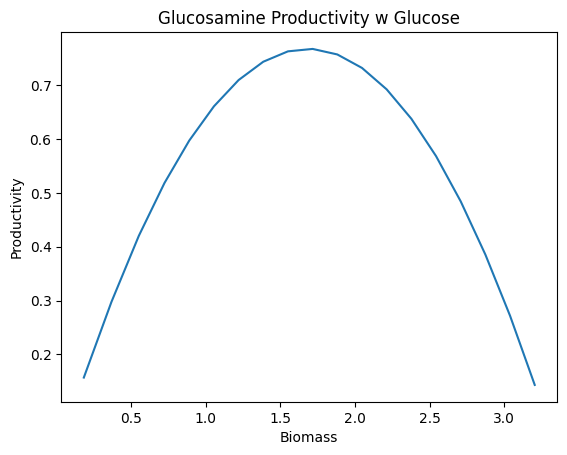

In [127]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],y[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('Glucosamine Productivity w Glucose') 
plt.show()

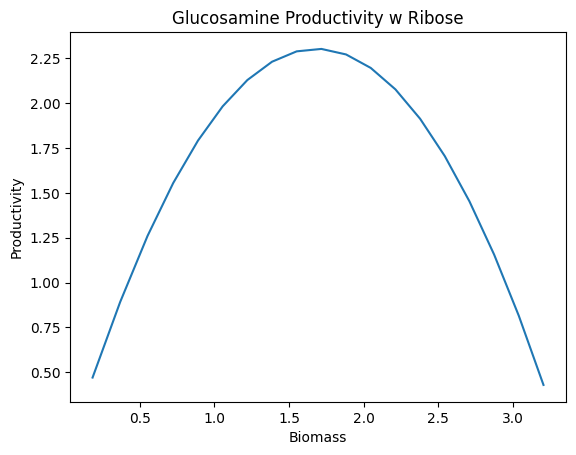

In [128]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],m[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('Glucosamine Productivity w Ribose') 
plt.show()

In [129]:
a=np.concatenate((np.asanyarray(x).flatten(),np.asanyarray(x).flatten()))

In [130]:
a=a.reshape(-1,19)

In [131]:
b=np.concatenate((np.asanyarray(m).flatten(),np.asanyarray(y).flatten()))
b=b.reshape(-1,19)

In [132]:
c=np.concatenate((np.asanyarray(y).flatten(),np.asanyarray(y).flatten()))
c=c.reshape(-1,19)

Text(0.5, 0, 'Growth')

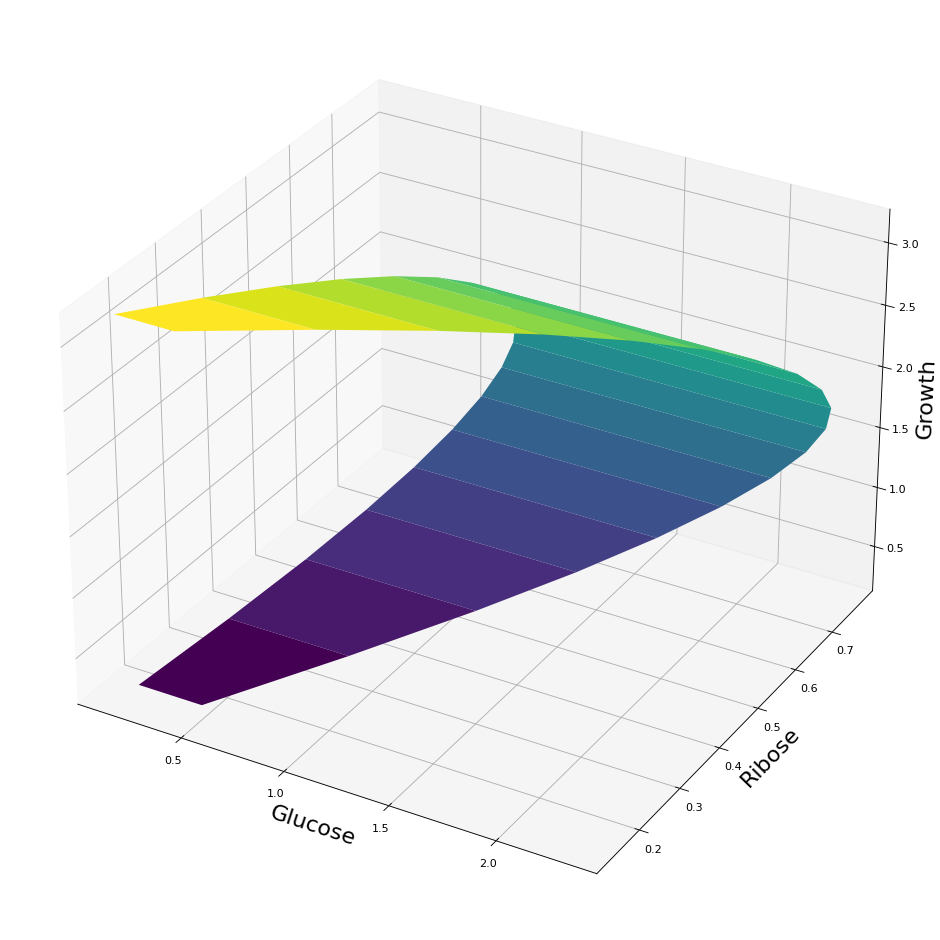

In [133]:
fig = plt.figure(figsize=(15, 15), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(b,c,a,
                rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Glucose', fontsize=20, rotation = 0)
ax.set_ylabel('Ribose', fontsize=20, rotation = 0)
ax.set_zlabel('Growth', fontsize=20, rotation = 0)

In [134]:
Biomass_sorted,Productivity1_sorted,Productivity2_sorted,GLSsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity1,Productivity2,Glucosamine,optimum_value)), key=lambda item: item[1], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,") # Higer than literature value
print("and the corresponding productivity will be", Productivity1_sorted[1], "mol/mol/h")
print("and the corresponding productivity will be", Productivity2_sorted[1], "mol/mol/h")
print("The Glucosamine production rate will be",GLSsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of Glucosamine is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  1.5515448326384873 /h,
and the corresponding productivity will be 0.7630268249661538 mol/mol/h
and the corresponding productivity will be 2.2890804748984612 mol/mol/h
The Glucosamine production rate will be 14.753556756756776 mmol/gdcw/h.
The optimum value set for production of Glucosamine is 0.5499999999999999


In [135]:
Biomass_sorted,Productivity1_sorted,Productivity2_sorted,GLSsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity1,Productivity2,Glucosamine,optimum_value)), key=lambda item: item[2], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,") # Higer than literature value
print("and the corresponding productivity will be", Productivity1_sorted[1], "mol/mol/h")
print("and the corresponding productivity will be", Productivity2_sorted[1], "mol/mol/h")
print("The Glucosamine production rate will be",GLSsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of Glucosamine is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  1.5515448326384873 /h,
and the corresponding productivity will be 0.7630268249661538 mol/mol/h
and the corresponding productivity will be 2.2890804748984612 mol/mol/h
The Glucosamine production rate will be 14.753556756756776 mmol/gdcw/h.
The optimum value set for production of Glucosamine is 0.5499999999999999


## Overexpression

In [136]:
model_growth = model.copy()

In [137]:
model_growth.objective = "BIOMASS_Ec_iML1515_core_75p37M"
model.objective = "EX_acgam_e"
model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45 # Paper reference

In [138]:
model.reactions.GF6PTA

Reaction identifier,GF6PTA
Name,Glutamine-fructose-6-phosphate transaminase
Memory address,0x23d921668e0
Stoichiometry,f6p_c + gln__L_c --> gam6p_c + glu__L_c D-Fructose 6-phosphate + L-Glutamine --> D-Glucosamine 6-phosphate + L-Glutamate
GPR,b3729
Lower bound,0.0
Upper bound,1000.0


In [139]:
print("Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:")
print("For Glutamine-fructose-6-phosphate transaminase: the flux increased from", model_growth.optimize().fluxes['GF6PTA'], "to", model.optimize().fluxes['GF6PTA'])

print("For Glutamine-fructose-6-phosphate transaminase, flux increased by:" , (model.optimize().fluxes['GF6PTA'] - model_growth.optimize().fluxes['GF6PTA'])/model_growth.optimize().fluxes['GF6PTA'] * 100, "%")

Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:
For Glutamine-fructose-6-phosphate transaminase: the flux increased from 0.31834025482243855 to 23.59969965148792
For Glutamine-fructose-6-phosphate transaminase, flux increased by: 7313.357027263544 %


## Using networkx to analyze the network

In [178]:
model = read_sbml_model('iML1515.xml')

In [179]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45

In [139]:
from cobra.util import create_stoichiometric_matrix
S = create_stoichiometric_matrix(model)

In [140]:
S

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [141]:
import numpy as np
S_hat = np.where(S==0, S, 1)
A_v = S_hat.T @ S_hat
A_x = S_hat @ S_hat.T

In [142]:
import networkx as nx

In [143]:
compound_centric_network = nx.from_numpy_matrix(A_x)

In [144]:
mapping = dict(zip(range(0, len(model.metabolites)), model.metabolites))
compound_centric_network = nx.relabel_nodes(compound_centric_network, mapping)

In [145]:
metabolite_degrees = compound_centric_network.degree()

In [146]:
sorted_metabolite_degrees = sorted(metabolite_degrees, key=lambda item: item[1], reverse=True)
sorted_metabolite_degrees[0:10]

[(<Metabolite h_c at 0x1baed134c40>, 1216),
 (<Metabolite h2o_c at 0x1baecfd95e0>, 864),
 (<Metabolite atp_c at 0x1baed1a25b0>, 610),
 (<Metabolite pi_c at 0x1baeda265b0>, 557),
 (<Metabolite adp_c at 0x1baee38f700>, 525),
 (<Metabolite h_p at 0x1baeda8a100>, 479),
 (<Metabolite ppi_c at 0x1baeeef2160>, 302),
 (<Metabolite nad_c at 0x1baeda8a1c0>, 298),
 (<Metabolite nadp_c at 0x1baeeef2340>, 294),
 (<Metabolite nadph_c at 0x1baee43a8e0>, 294)]

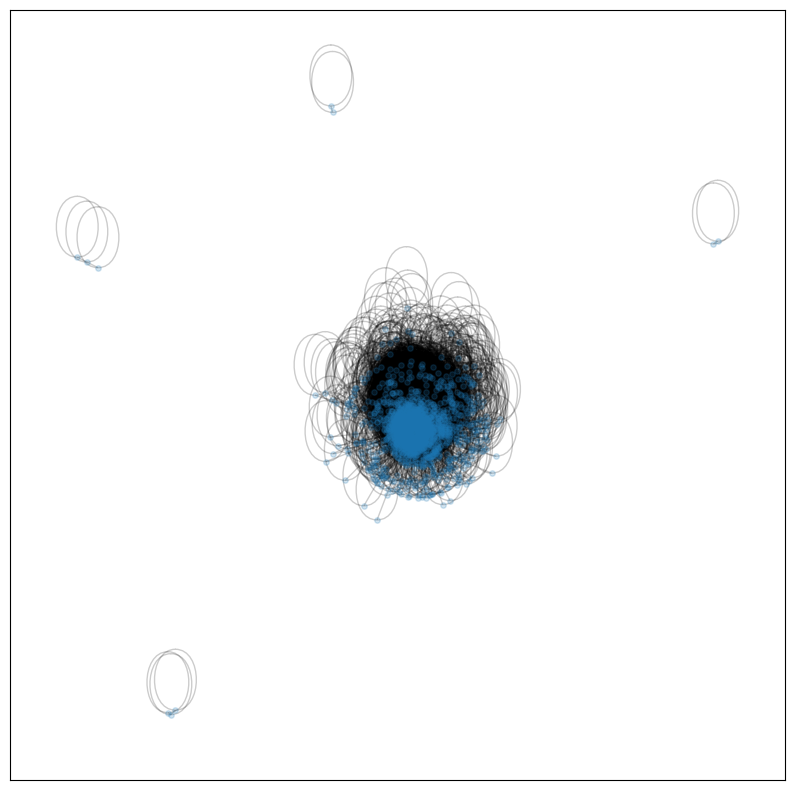

In [147]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(compound_centric_network, node_size=15, alpha=.2, with_labels=False)

In [148]:
a=list(compound_centric_network.nodes)[565]
b=list(compound_centric_network.nodes)[420]
for i in range(len(list(compound_centric_network.nodes))):
    print(i, list(compound_centric_network.nodes)[i])

0 octapb_c
1 cysi__L_e
2 dhap_c
3 prbatp_c
4 10fthf_c
5 btal_c
6 6pgg_c
7 co2_e
8 akg_e
9 gsn_e
10 pydx5p_c
11 3dhgulnp_c
12 g3ps_c
13 adphep_LD_c
14 lyx__L_c
15 din_p
16 2pg_c
17 ptrc_p
18 malt_p
19 pppn_p
20 arbtn_p
21 hphhlipa_c
22 phphhlipa_c
23 13dpg_c
24 murein3px4p_p
25 34dhpac_e
26 1odec11eg3p_c
27 12dgr181_p
28 anhgm_e
29 prbamp_c
30 dsbdrd_c
31 cu2_p
32 sla_c
33 14glucan_p
34 grdp_c
35 ribflv_p
36 dms_e
37 pgp141_c
38 cysi__L_c
39 fpram_c
40 f1p_c
41 dsbard_p
42 thr__L_c
43 dcyt_p
44 2ddglcn_c
45 fum_p
46 galctn__L_e
47 btn_e
48 pydxn_p
49 ocdcea_e
50 preq0_c
51 tyr__L_p
52 dtdp4d6dg_c
53 acmum_e
54 man_p
55 adocbl_e
56 iscu_2fe2s_c
57 frulysp_c
58 dump_p
59 novbcn_e
60 feenter_e
61 eca4und_p
62 gg4abut_c
63 flxr_c
64 pa160_c
65 lcts_c
66 arbtn_e
67 cdpdhdec9eg_c
68 aso3_c
69 progly_c
70 3ohdcoa_c
71 clpn161_p
72 1ddecg3p_p
73 gln__L_e
74 cpgn_un_e
75 ca2_p
76 tre_e
77 iscssh_c
78 glyald_c
79 alaala_e
80 novbcn_p
81 3ohexACP_c
82 g3pg_c
83 rpntp_c
84 adocbl_c
85 3ocddec5eACP_

In [149]:
print(nx.shortest_path(compound_centric_network, source=a, target=b))

[<Metabolite glc__D_c at 0x1baed1abb50>, <Metabolite h_c at 0x1baed134c40>, <Metabolite uacgam_c at 0x1baef4e82e0>, <Metabolite puacgam_c at 0x1baeeef2280>, <Metabolite puacgam_p at 0x1baee38fa30>]


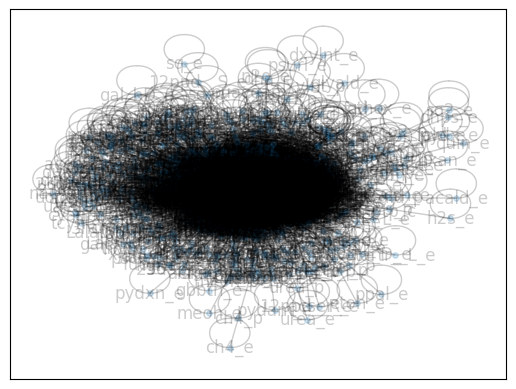

In [150]:
A = (compound_centric_network.subgraph(c) for c in nx.connected_components(compound_centric_network))
A = list(A)[0]
nx.draw_networkx(A, node_size=15, alpha=.2, with_labels=True)

In [151]:
acgam_p = list(compound_centric_network.nodes)[1607]
acgam6p_c = list(compound_centric_network.nodes)[133]
gam6p_c = list(compound_centric_network.nodes)[1443]

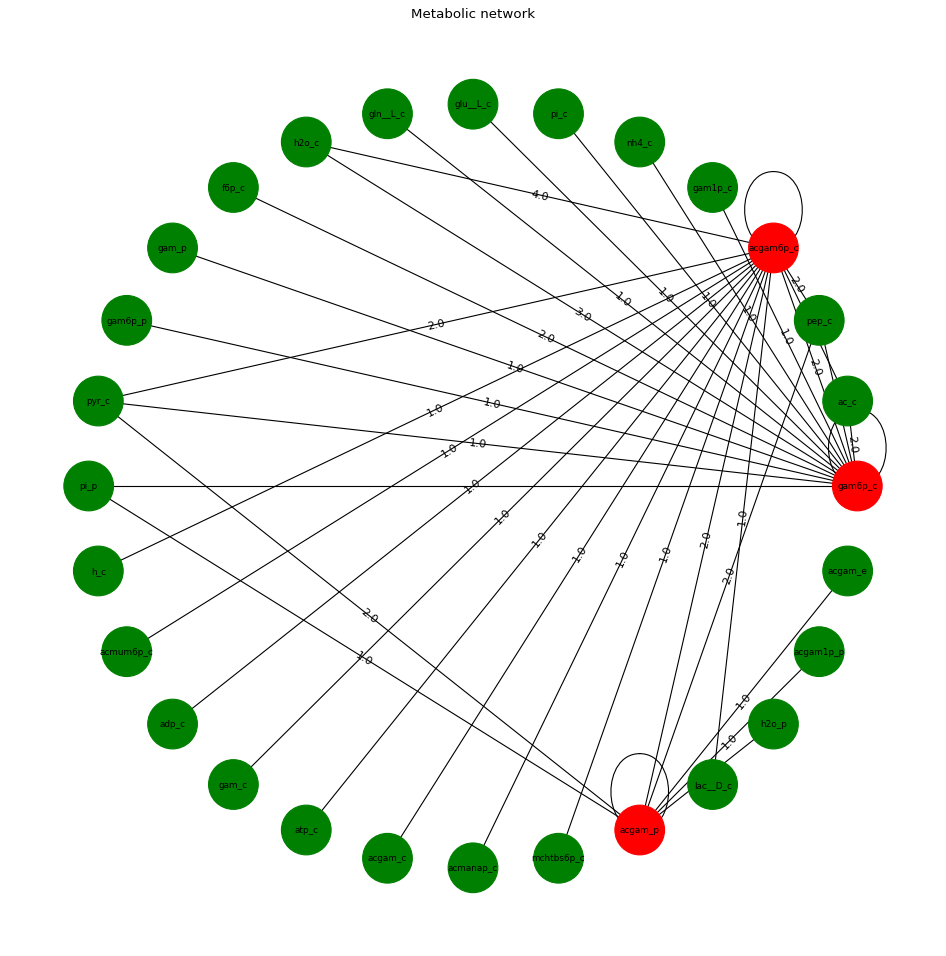

In [152]:
def check_neighbor_weights(g,nodes):
    subg=nx.Graph() #Create subgraph
    for n in nodes:
        subg.add_node(n)
        neighbors=g.neighbors(n) #Find all neighbors of node n
        for neighs in neighbors:
            if g[n][neighs]['weight']<50: #Check if the weigh t is below 50
                subg.add_edge(n,neighs,weight=g[n][neighs]['weight'])
    return subg

subg=check_neighbor_weights(compound_centric_network,[gam6p_c, acgam6p_c, acgam_p]) #Returns subgraph of interest

color_map = []
for node in subg.nodes():
    if node in [gam6p_c, acgam6p_c, acgam_p]:
        color_map.append('red')
    else: 
        color_map.append('green')      


plt.figure(figsize=(15, 15), dpi=80)
plt.title('Metabolic network')
labels_subg = nx.get_edge_attributes(subg,'weight')
pos_subg=nx.circular_layout(subg)
nx.draw_networkx_edge_labels(subg,pos=pos_subg,edge_labels=labels_subg)
nx.draw(subg,pos=pos_subg,with_labels=True,node_color=color_map,node_size=2000,font_size=8)

plt.show()

# OptGene

In [86]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

In [87]:
# gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("accoa_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("coa_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("adp_c"): -1.0,
    model.metabolites.get_by_id("atp_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])


In [88]:
optgene = OptGene(model)

In [89]:
result = optgene.run(target=model.reactions.EX_acgam_e, 
                     biomass=model.reactions.BIOMASS_Ec_iML1515_core_75p37M,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000, population_size=200, max_knockouts=1000,
                     plot=True, growth_coupled=True)

Starting optimization at Wed, 30 Nov 2022 14:51:34


HBox()

Finished after 02:16:56


In [90]:
result

No solutions found


IndexError: index 0 is out of bounds for axis 0 with size 0

# dFBA

In [2]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable

model = read_sbml_model('iML1515.xml')

In [3]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

# gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("accoa_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("coa_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("adp_c"): -1.0,
    model.metabolites.get_by_id("atp_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45
model.objective = model.reactions.EX_acgam_e

In [4]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [5]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Rib = KineticVariable("Ribose")
Oxy = KineticVariable("Oxygen")
Gluc_amine = KineticVariable("Glucosamine")

dfba_model.add_kinetic_variables([X, Gluc, Rib, Oxy, Gluc_amine])

In [6]:
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_G = ExchangeFlux("EX_glc__D_e")
v_R = ExchangeFlux("EX_rib__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_GS = ExchangeFlux("EX_acgam_e")

dfba_model.add_exchange_fluxes([mu, v_G, v_R, v_O, v_GS])

In [7]:
dfba_model.add_rhs_expression("Biomass", mu * X - 0.2 * X)
# dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
# dfba_model.add_rhs_expression("Ribose", v_R * 150.13/1000 * X)
dfba_model.add_rhs_expression("Glucose", 0) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Ribose", 0)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Glucosamine", v_GS * 221.2078/1000 * X)

In [8]:
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)


vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb(
    "EX_glc__D_e",
    vmax_glc * (Gluc / (Kg + Gluc)),
    Gluc
)

vmax_rib = 6 # [mmol gDW^-1 h^-1]
Kr = 0.0165
dfba_model.add_exchange_flux_lb(
    "EX_rib__D_e",
    vmax_rib 
    * (Rib / (Kr + Rib)),
    Rib,
)

dfba_model.add_exchange_flux_lb(
    "BIOMASS_Ec_iML1515_core_75p37M",
    0.45 * (X / (0.2 + X)),
    X,
)


In [9]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 30, # (g/L)
        "Ribose": 10.0,   # (g/L)
        "Oxygen": 0.5,  # (mmol/L)
        "Glucosamine": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 100.0, 0.1, ["EX_glc__D_e", "EX_rib__D_e", "EX_acgam_e", "BIOMASS_Ec_iML1515_core_75p37M"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 0
Number of residual evaluations     = 0
Number of Jacobian evaluations     = 21
Number of nonlinear iterations     = 0
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 0

Total simulation time was 4.45771 seconds



In [10]:
concentrations

,time,Biomass,Glucosamine,Glucose,Oxygen,Ribose
0,0.0,0.010000,0.000000,30.0,0.5,10.0
1,0.1,0.010231,0.025845,30.0,0.5,10.0
2,0.2,0.010467,0.052289,30.0,0.5,10.0
3,0.3,0.010708,0.079351,30.0,0.5,10.0
4,0.4,0.010953,0.107034,30.0,0.5,10.0
...,...,...,...,...,...,...
996,99.6,0.249838,523.817353,30.0,0.5,10.0
997,99.7,0.249839,524.456456,30.0,0.5,10.0
998,99.8,0.249839,525.095554,30.0,0.5,10.0
999,99.9,0.249840,525.734648,30.0,0.5,10.0


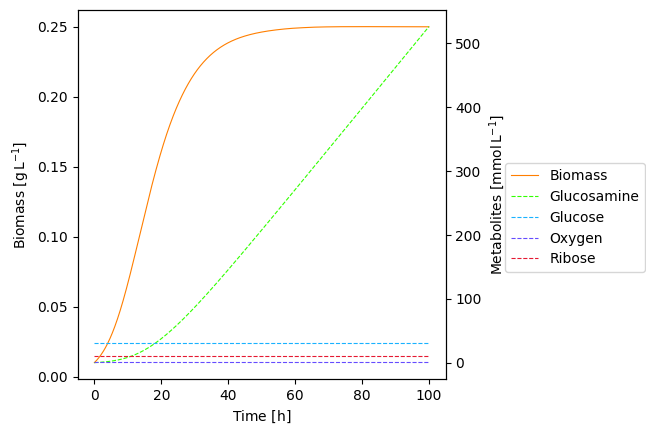

In [11]:
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

In [12]:
trajectories

,time,EX_glc__D_e,EX_rib__D_e,EX_acgam_e,BIOMASS_Ec_iML1515_core_75p37M
0,0.0,0.000000,0.000000,0.000000,0.000000
1,0.1,-10.499055,-5.990116,115.504055,0.428101
2,0.2,-10.499055,-5.990116,115.504250,0.427621
3,0.3,-10.499055,-5.990116,115.504449,0.427132
4,0.4,-10.499055,-5.990116,115.504652,0.426635
...,...,...,...,...,...
996,99.6,-10.499055,-5.990116,115.596955,0.200072
997,99.7,-10.499055,-5.990116,115.596955,0.200072
998,99.8,-10.499055,-5.990116,115.596955,0.200071
999,99.9,-10.499055,-5.990116,115.596955,0.200071


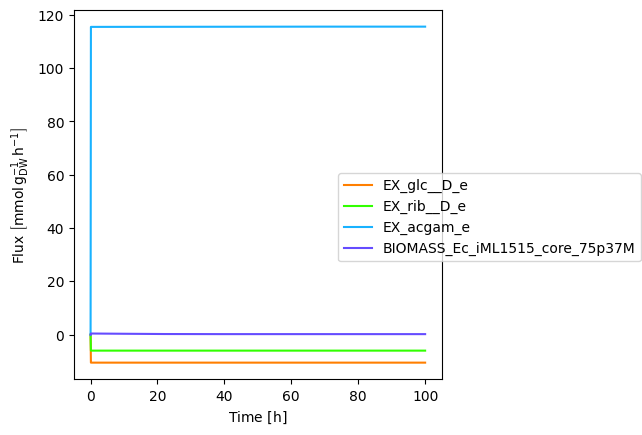

In [13]:
plot_trajectories(trajectories)

# FSEOF

In [91]:
model = read_sbml_model('iML1515.xml')

In [92]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

# gene knockout
model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

# gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("accoa_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("coa_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("adp_c"): -1.0,
    model.metabolites.get_by_id("atp_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45

In [93]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [94]:
fseof = FSEOF(model)

In [95]:
result = fseof.run(target=model.reactions.EX_acgam_e)

In [96]:
result.data_frame 

,1,2,3,4,5,6,7,8,9,10
DHORD5,1.028083,0.941683,0.855282,0.768881,0.682480,0.596080,0.509679,0.423278,0.336877,0.250477
VALTA,-3.123475,-2.860976,-2.598477,-2.335979,-2.073480,-1.810981,-1.548482,-1.285984,-1.023485,-0.760986
FRD2,1.028083,0.941683,0.855282,0.768881,0.682480,0.596080,0.509679,0.423278,0.336877,0.250477
PGI,21.310963,21.770079,22.229195,22.688310,23.147426,23.606542,24.065657,24.524773,24.983888,25.443004
ADK1,-32.364749,-31.400887,-30.437026,-29.473165,-28.509304,-27.545443,-26.581582,-25.617721,-24.653860,-23.689998
ACCOAL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289733
PPCSCT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289733
GF6PTA,2.413807,4.509274,6.604741,8.700207,10.795674,12.891141,14.986608,17.082074,19.177541,21.273008
SPODM,0.012133,0.011114,0.010094,0.009074,0.008055,0.007035,0.006015,0.004995,0.003976,0.002956
ADK3,40.518358,38.869263,37.220168,35.571072,33.921977,32.272881,30.623786,28.974690,27.325595,25.676499


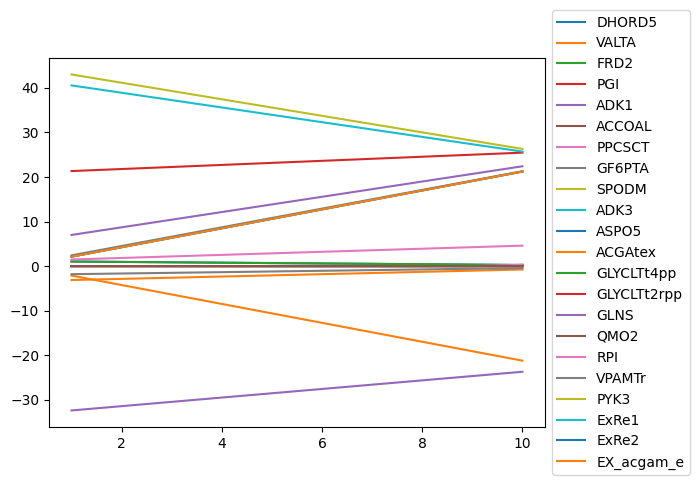

In [97]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [98]:
res = result.data_frame

In [99]:
res["diff"] = abs(result.data_frame[:][10] - result.data_frame[:][1])

In [100]:
res = res.sort_values("diff", ascending=False)
res

,1,2,3,4,5,6,7,8,9,10,diff
ACGAtex,-2.120146,-4.240292,-6.360439,-8.480585,-10.600731,-12.720877,-14.841023,-16.961170,-19.081316,-21.201462,19.081316
ExRe1,2.120146,4.240292,6.360439,8.480585,10.600731,12.720877,14.841023,16.961170,19.081316,21.201462,19.081316
ExRe2,2.120146,4.240292,6.360439,8.480585,10.600731,12.720877,14.841023,16.961170,19.081316,21.201462,19.081316
EX_acgam_e,2.120146,4.240292,6.360439,8.480585,10.600731,12.720877,14.841023,16.961170,19.081316,21.201462,19.081316
GF6PTA,2.413807,4.509274,6.604741,8.700207,10.795674,12.891141,14.986608,17.082074,19.177541,21.273008,18.859201
PYK3,42.973656,41.118216,39.262776,37.407336,35.551895,33.696455,31.841015,29.985575,28.130135,26.274695,16.698961
GLNS,6.988564,8.699565,10.410567,12.121568,13.832570,15.543571,17.254572,18.965574,20.676575,22.387577,15.399013
ADK3,40.518358,38.869263,37.220168,35.571072,33.921977,32.272881,30.623786,28.974690,27.325595,25.676499,14.841859
ADK1,-32.364749,-31.400887,-30.437026,-29.473165,-28.509304,-27.545443,-26.581582,-25.617721,-24.653860,-23.689998,8.674751
PGI,21.310963,21.770079,22.229195,22.688310,23.147426,23.606542,24.065657,24.524773,24.983888,25.443004,4.132041


In [101]:
res = res.iloc[:,:-1].head(10)
res

,1,2,3,4,5,6,7,8,9,10
ACGAtex,-2.120146,-4.240292,-6.360439,-8.480585,-10.600731,-12.720877,-14.841023,-16.961170,-19.081316,-21.201462
ExRe1,2.120146,4.240292,6.360439,8.480585,10.600731,12.720877,14.841023,16.961170,19.081316,21.201462
ExRe2,2.120146,4.240292,6.360439,8.480585,10.600731,12.720877,14.841023,16.961170,19.081316,21.201462
EX_acgam_e,2.120146,4.240292,6.360439,8.480585,10.600731,12.720877,14.841023,16.961170,19.081316,21.201462
GF6PTA,2.413807,4.509274,6.604741,8.700207,10.795674,12.891141,14.986608,17.082074,19.177541,21.273008
PYK3,42.973656,41.118216,39.262776,37.407336,35.551895,33.696455,31.841015,29.985575,28.130135,26.274695
GLNS,6.988564,8.699565,10.410567,12.121568,13.832570,15.543571,17.254572,18.965574,20.676575,22.387577
ADK3,40.518358,38.869263,37.220168,35.571072,33.921977,32.272881,30.623786,28.974690,27.325595,25.676499
ADK1,-32.364749,-31.400887,-30.437026,-29.473165,-28.509304,-27.545443,-26.581582,-25.617721,-24.653860,-23.689998
PGI,21.310963,21.770079,22.229195,22.688310,23.147426,23.606542,24.065657,24.524773,24.983888,25.443004


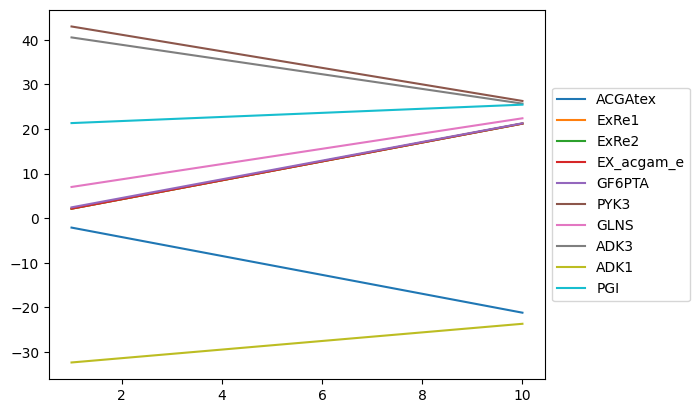

In [102]:
res.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# MEMOTE

In [2]:
from cobra.io import write_sbml_model
write_sbml_model(model, "iML1515_modified.xml")

In [3]:
%%time
!memote report snapshot iML1515.xml --filename iML1515.html

Scaling...Wall time: 5min 27s


Writing snapshot report to 'iML1515.html'.



 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py ...F...F.....FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss.FFFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%]
test_mat

In [4]:
%%time
!memote report snapshot iML1515_modified.xml --filename iML1515_modified.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py ...F...F.....FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss.FFFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%

Writing snapshot report to 'iML1515_modified.html'.


In [5]:
%%time
!memote report snapshot iJR904.xml --filename iJR904.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 146 items / 1 skipped / 145 selected

test_annotation.py ...FFFFFFFF..FFFF..FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 36%]
F..FF.FFF...                                                             [ 44%]
test_basic.py ......F............F.FF                                    [ 60%]
test_biomass.py .F.....F.F                                               [ 67%]
test_consistency.py ...ssssssssssssssssFFFFFF.FFF                        [ 86%]
test_essentiality.py s                                                   [ 87%]
test_growth.py s                                                         [ 88%

Writing snapshot report to 'iJR904.html'.


In [6]:
%%time
!memote report snapshot iAF1260.xml --filename iAF1260.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 146 items / 1 skipped / 145 selected

test_annotation.py ...FFFFFFFF..FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 36%]
F..FF.FFF...                                                             [ 44%]
test_basic.py ......F............F.FF                                    [ 60%]
test_biomass.py .F.....F.F                                               [ 67%]
test_consistency.py ...ssssssssssssssss..FFFF.FFF                        [ 86%]
test_essentiality.py s                                                   [ 87%]
test_growth.py s                                                         [ 88%

Writing snapshot report to 'iAF1260.html'.


In [7]:
%%time
!memote report snapshot iJO1366.xml --filename iJO1366.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFF..FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py .............FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss..FFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%

Writing snapshot report to 'iJO1366.html'.
